In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, LSTM, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import gc
import tensorflow as tf
import random
from sklearn import preprocessing
import pickle
import tqdm

In [2]:
#Load config
with open('Data_Set/config.pickle', 'rb') as data:
    config = pickle.load(data)
dataSetSize = config["dataSetSize"]
testSetBenignSize = config["testSetBenignSize"]
validationSetSize = config["validationSetSize"]
trainingSetSize = config["trainingSetSize"]
sequenceLen = config["sequenceLen"]
dimensionsCount = config["dimensionsCount"]
numberOfAttackSamplesToChoose = 100
testSetSize = testSetBenignSize + numberOfAttackSamplesToChoose

In [3]:
with open('Data_set/normalized_data_set.pickle', 'rb') as data:
    normalizedDataSet = pickle.load(data)
dataSet = np.reshape(normalizedDataSet, (dataSetSize,sequenceLen,dimensionsCount), order = 'C')

In [4]:
model = load_model('Trained_Model/lstm.h5')
predicted = model.predict(dataSet)

In [5]:
# Sample gradients
# Single variable
import numdifftools as nd
  
  
g = lambda x:(x**4)+x + 1
grad1 = nd.Gradient(g)([1,1,2])
print("Gradient of x ^ 4 + x+1 at x = [1,1,2] is ", grad1)
  
def rosen(x): 
    return (1-x[0])**2 +(x[1]-x[0]**2)**2
  
grad2 = nd.Gradient(rosen)([1, 2])
print("Gradient of (1-x ^ 2)+(y-x ^ 2)^2 at (1, 2) is ", grad2)

Gradient of x ^ 4 + x+1 at x = [1,1,2] is  [[ 5.  0.  0.]
 [ 0.  5.  0.]
 [ 0.  0. 33.]]
Gradient of (1-x ^ 2)+(y-x ^ 2)^2 at (1, 2) is  [-4.  2.]


In [6]:
# Convert sequential to functional model
from tensorflow.keras import layers, models

input_layer = layers.Input(batch_shape=model.layers[0].input_shape)
prev_layer = input_layer
for layer in model.layers:
    prev_layer = layer(prev_layer)

funcmodel = models.Model([input_layer], [prev_layer])

In [35]:
loss_object = tf.keras.losses.MeanSquaredError()

@tf.function # To fix: 'Tensor' object has no attribute 'numpy' 
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = funcmodel(input_image)
        #loss = loss_object(input_label, prediction)
        loss = loss_object(input_image, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [36]:
sample = np.reshape(dataSet[0,:,:], (1,sequenceLen,dimensionsCount), order = 'C')
sample.shape
tfInput = tf.cast(tf.convert_to_tensor(sample),tf.float32)
tfOutput = tfInput

In [37]:
sgrad = create_adversarial_pattern(tfInput, tfOutput)

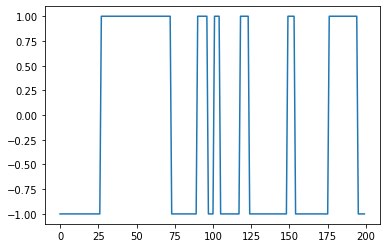

In [38]:
plt.plot(sgrad[0,:,6])

In [39]:
sgrad.numpy().shape

(1, 200, 9)

(1, 200, 9)
(1, 200, 9)
(1, 200, 9)
(1, 200, 9)


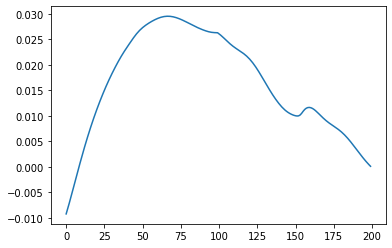

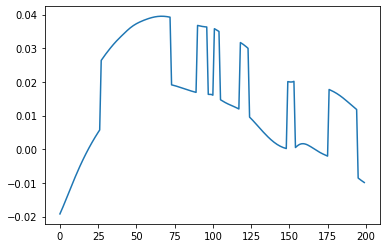

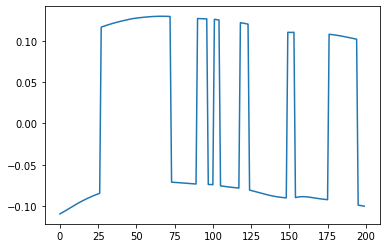

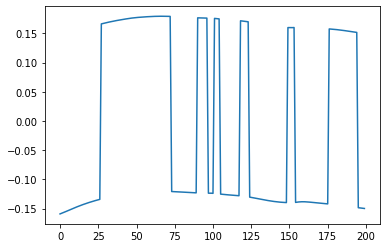

<Figure size 432x288 with 0 Axes>

In [40]:
epsilons = [0, 0.01, 0.1, 0.15]

descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    perturbations = eps*sgrad
    adv_x = dataSet[0,:,:] + perturbations
    #adv_x = tf.clip_by_value(adv_x, -1, 1)
    #display_images(adv_x, descriptions[i])
    print(adv_x.shape)    
    plt.plot(adv_x[0,:,6])
    plt.figure()

(1, 200, 9)


<Figure size 432x288 with 0 Axes>

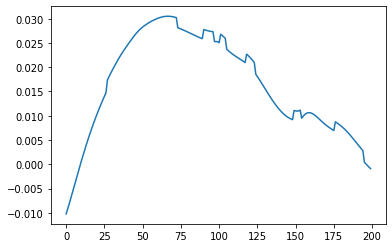

<Figure size 432x288 with 0 Axes>

In [41]:
epsilons = 0.001

perturbations = epsilons*sgrad
adv_x = dataSet[0,:,:] + perturbations
#adv_x = tf.clip_by_value(adv_x, -1, 1)
#display_images(adv_x, descriptions[i])
print(adv_x.shape)    
plt.plot(adv_x[0,:,6])
plt.figure()

In [42]:
predicted = model.predict(sample)
mse = (np.square(sample - predicted)).mean(axis=2).mean(axis=1)
print(mse)
predicted = model.predict(adv_x)
mse = (np.square(adv_x - predicted)).mean(axis=2).mean(axis=1)
print(mse)

[3.06653915e-05]
[3.557557e-05]


In [43]:
@tf.function 
def mzAttackSampleGenerator(iterations,seed,epsilon):
    tfInput = tfoutput = seed
    for step in range(0,iterations):
        tfInput = seed
        tfOutput = tfInput
        sgrad = create_adversarial_pattern(tfInput, tfOutput)                
        epsilon = 0.001
        perturbations = epsilon*sgrad
        seed = seed + perturbations    
        #print(perturbations.shape)
        #print(adv_x.shape)    
        #plt.plot(adv_x[0,:,6])
        #plt.figure()    
    attackSample = seed
    return attackSample

[3.06653915e-05]
[6.997945e-05]


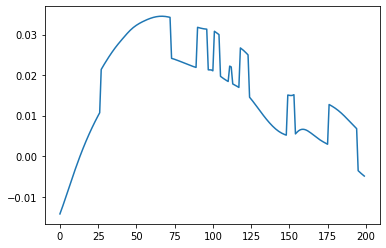

In [44]:
sample = np.reshape(dataSet[0,:,:], (1,sequenceLen,dimensionsCount), order = 'C')
attackSample = mzAttackSampleGenerator(5,sample,0.001)
plt.plot(attackSample[0,:,6])
predicted = model.predict(sample)
mse = (np.square(sample - predicted)).mean(axis=2).mean(axis=1)
print(mse)
predicted = model.predict(adv_x)
mse = (np.square(attackSample - predicted)).mean(axis=2).mean(axis=1)
print(mse)

[3.06653915e-05]
[0.00015772]


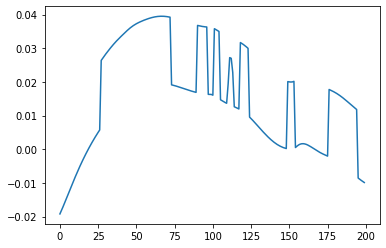

In [45]:
sample = np.reshape(dataSet[0,:,:], (1,sequenceLen,dimensionsCount), order = 'C')
attackSample = mzAttackSampleGenerator(10,sample,0.001)
plt.plot(attackSample[0,:,6])
predicted = model.predict(sample)
mse = (np.square(sample - predicted)).mean(axis=2).mean(axis=1)
print(mse)
predicted = model.predict(adv_x)
mse = (np.square(attackSample - predicted)).mean(axis=2).mean(axis=1)
print(mse)

[3.06653915e-05]
[0.00071872]


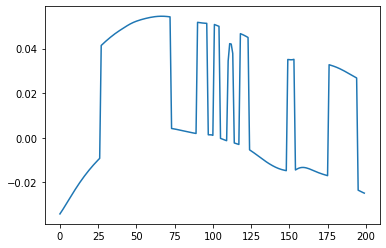

In [46]:
sample = np.reshape(dataSet[0,:,:], (1,sequenceLen,dimensionsCount), order = 'C')
attackSample = mzAttackSampleGenerator(25,sample,0.001)
plt.plot(attackSample[0,:,6])
predicted = model.predict(sample)
mse = (np.square(sample - predicted)).mean(axis=2).mean(axis=1)
print(mse)
predicted = model.predict(adv_x)
mse = (np.square(attackSample - predicted)).mean(axis=2).mean(axis=1)
print(mse)

[3.06653915e-05]
[0.00265279]


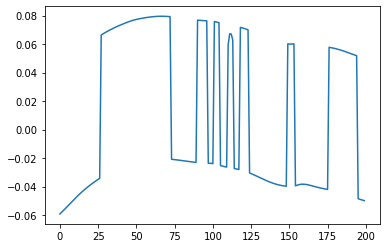

In [47]:
sample = np.reshape(dataSet[0,:,:], (1,sequenceLen,dimensionsCount), order = 'C')
attackSample = mzAttackSampleGenerator(50,sample,0.001)
plt.plot(attackSample[0,:,6])
predicted = model.predict(sample)
mse = (np.square(sample - predicted)).mean(axis=2).mean(axis=1)
print(mse)
predicted = model.predict(adv_x)
mse = (np.square(attackSample - predicted)).mean(axis=2).mean(axis=1)
print(mse)

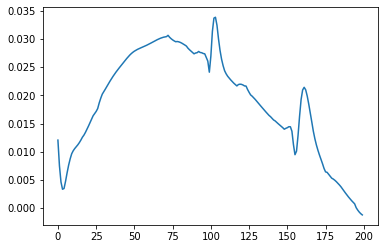

In [48]:
plt.plot(predicted[0,:,6])

### In other direction with 0 sequence seed

In [71]:
@tf.function 
def mzAttackSampleGeneratorFromZero(iterations,seed,epsilon):
    tfInput = tfoutput = seed
    for step in range(0,iterations):
        tfInput = seed
        tfOutput = tfInput
        sgrad = create_adversarial_pattern(tfInput, tfOutput)                        
        perturbations = epsilon*sgrad
        seed = seed - perturbations    
        #print(perturbations.shape)
        #print(adv_x.shape)    
        #plt.plot(adv_x[0,:,6])
        #plt.figure()    
    attackSample = seed
    return attackSample

[0.00012168]
[1.6487107e-06]


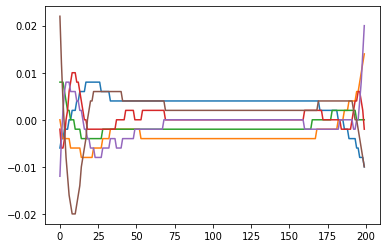

In [87]:
sample = np.reshape(dataSet[0,:,:], (1,sequenceLen,dimensionsCount), order = 'C')
sample = np.zeros((1,sequenceLen,dimensionsCount))
randSample = np.random.rand(1,sequenceLen,dimensionsCount)

attackSample = mzAttackSampleGeneratorFromZero(300,sample,0.001)
plt.plot(attackSample[0,:,0])
plt.plot(attackSample[0,:,1])
plt.plot(attackSample[0,:,2])
plt.plot(attackSample[0,:,3])
plt.plot(attackSample[0,:,4])
plt.plot(attackSample[0,:,5])
#attackSample = mzAttackSampleGeneratorFromZero(5,attackSample,0.01)
#print(type(attackSample))
#plt.plot(attackSample[0,:,6])



predicted = model.predict(sample)
mse = (np.square(sample - predicted)).mean(axis=2).mean(axis=1)
print(mse)
predicted = model.predict(attackSample)
mse = (np.square(attackSample - predicted)).mean(axis=2).mean(axis=1)
print(mse)

[0.22130592]
[1.60835174e-06]


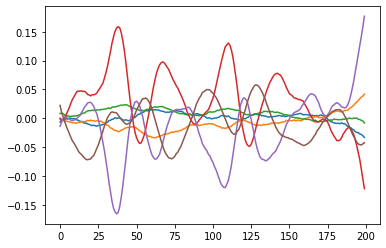

In [92]:
randSample = np.random.rand(1,sequenceLen,dimensionsCount)

attackSample = mzAttackSampleGeneratorFromZero(2000,randSample,0.001)
plt.plot(attackSample[0,:,0])
plt.plot(attackSample[0,:,1])
plt.plot(attackSample[0,:,2])
plt.plot(attackSample[0,:,3])
plt.plot(attackSample[0,:,4])
plt.plot(attackSample[0,:,5])
#attackSample = mzAttackSampleGeneratorFromZero(5,attackSample,0.01)
#print(type(attackSample))
#plt.plot(attackSample[0,:,6])



predicted = model.predict(randSample)
mse = (np.square(randSample - predicted)).mean(axis=2).mean(axis=1)
print(mse)
predicted = model.predict(attackSample)
mse = (np.square(attackSample - predicted)).mean(axis=2).mean(axis=1)
print(mse)

In [115]:
# Generating attack samples from random seeds
for i in tqdm.tqdm(range(100)):
    randSample = np.random.rand(1,sequenceLen,dimensionsCount)
    mse = 1000
    attackSample = randSample
    while mse > pow(10,(-5)):
        attackSample = mzAttackSampleGeneratorFromZero(1,attackSample,0.001)
        predicted = model.predict(attackSample)
        mse = (np.square(attackSample - predicted)).mean(axis=2).mean(axis=1)        
    attackSamples.append(attackSample)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [3:34:35<00:00, 128.75s/it]


In [116]:
dataArray = np.array(attackSamples)
with open('Data_Set/adversarial_data_set_from_random_seeds.pickle', 'wb') as handle:
    pickle.dump(dataArray, handle)

In [109]:
attackSamples = list()
attackSamples.append(attackSample)

1

### generating adversarial samples

In [43]:
dataList = list()
for i in range(20):
    sample = np.reshape(dataSet[0,:,:], (1,sequenceLen,dimensionsCount), order = 'C')
    attackSample = mzAttackSampleGenerator(5,sample,0.001)    
    dataList.append(np.reshape(attackSample,(200,9), order = 'C'))
    
print(len(dataList))

20


In [44]:
dataArray = np.array(dataList)
with open('Data_Set/adversarial_data_set.pickle', 'wb') as handle:
    pickle.dump(dataArray, handle)

In [45]:
dataArray.shape

(20, 200, 9)

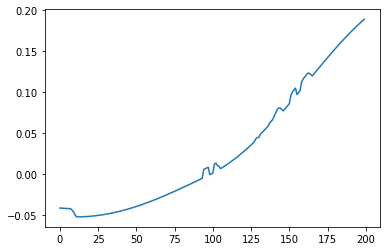

In [46]:
plt.plot(dataArray[1,:,0])